In [1]:
# -*- coding: utf-8 -*-
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

import time
import os
import copy

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cuda')

In [12]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip


'wget'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


In [13]:
data_transforms = {'train':transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229,0.224,0.225])]),
                   'val': transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406], [0.229,0.224,0.225])])}

In [14]:
data_dir = './hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=4, shuffle=True,num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [15]:
print(class_names)

['ants', 'bees']


In [16]:
model_ft = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\bitcamp/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:03<00:00, 12.0MB/s]


In [17]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

In [19]:
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

In [20]:
exp_lr_scheduler= lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [26]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-'*10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs,1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss/ dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f}\tAccuracy: {:.4f}'.format(phase, epoch_loss,epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
    
    time_elapsed = time.time() - since
    print('Training time: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Validation Accuracy: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [27]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.2229	Accuracy: 0.9098
val Loss: 0.2688	Accuracy: 0.9150

Epoch 1/24
----------
train Loss: 0.3094	Accuracy: 0.8525
val Loss: 0.2539	Accuracy: 0.9020

Epoch 2/24
----------
train Loss: 0.2366	Accuracy: 0.9139
val Loss: 0.2443	Accuracy: 0.9346

Epoch 3/24
----------
train Loss: 0.2511	Accuracy: 0.8730
val Loss: 0.2365	Accuracy: 0.9412

Epoch 4/24
----------
train Loss: 0.2800	Accuracy: 0.8811
val Loss: 0.2469	Accuracy: 0.9346

Epoch 5/24
----------
train Loss: 0.2791	Accuracy: 0.8730
val Loss: 0.2384	Accuracy: 0.9346

Epoch 6/24
----------
train Loss: 0.2247	Accuracy: 0.8852
val Loss: 0.2931	Accuracy: 0.8889

Epoch 7/24
----------
train Loss: 0.2567	Accuracy: 0.9057
val Loss: 0.2279	Accuracy: 0.9346

Epoch 8/24
----------
train Loss: 0.2608	Accuracy: 0.8893
val Loss: 0.2423	Accuracy: 0.9412

Epoch 9/24
----------
train Loss: 0.2835	Accuracy: 0.8689
val Loss: 0.2382	Accuracy: 0.9281

Epoch 10/24
----------
train Loss: 0.2510	Accuracy: 0.9016
val Loss: 0

In [28]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    fig = plt.figure(figsize=(10,5))
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

In [40]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
                    
            
            model.train(mode=was_training)


    
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


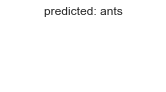

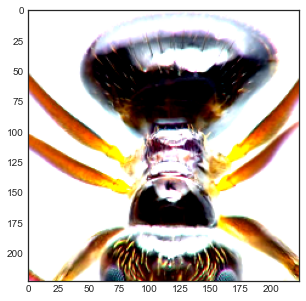

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


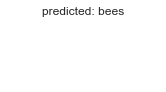

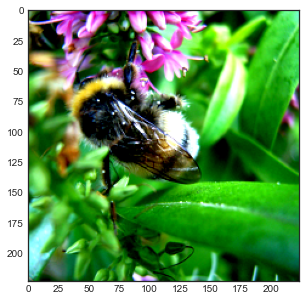

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


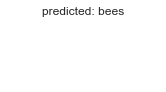

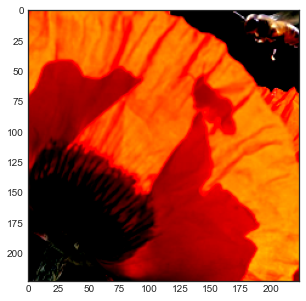

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


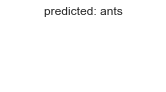

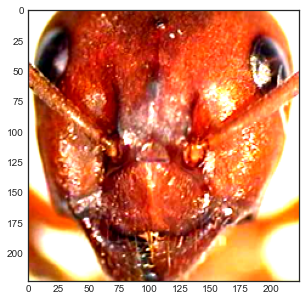

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


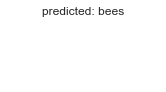

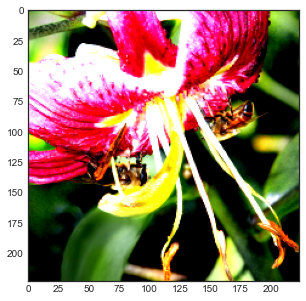

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


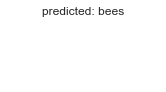

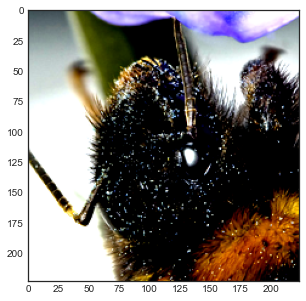

In [41]:
visualize_model(model_ft)

In [43]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
    
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)



In [44]:
model_conv= train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5451	Accuracy: 0.6844
val Loss: 0.3194	Accuracy: 0.8693

Epoch 1/24
----------
train Loss: 0.5376	Accuracy: 0.7295
val Loss: 0.2504	Accuracy: 0.9216

Epoch 2/24
----------
train Loss: 0.4624	Accuracy: 0.7910
val Loss: 0.1982	Accuracy: 0.9412

Epoch 3/24
----------
train Loss: 0.4631	Accuracy: 0.7992
val Loss: 0.2438	Accuracy: 0.9216

Epoch 4/24
----------
train Loss: 0.4655	Accuracy: 0.8238
val Loss: 0.3114	Accuracy: 0.8824

Epoch 5/24
----------
train Loss: 0.4015	Accuracy: 0.8320
val Loss: 0.3276	Accuracy: 0.8889

Epoch 6/24
----------
train Loss: 0.4529	Accuracy: 0.8238
val Loss: 0.2031	Accuracy: 0.9412

Epoch 7/24
----------
train Loss: 0.3783	Accuracy: 0.8197
val Loss: 0.1966	Accuracy: 0.9477

Epoch 8/24
----------
train Loss: 0.3776	Accuracy: 0.8607
val Loss: 0.2032	Accuracy: 0.9412

Epoch 9/24
----------
train Loss: 0.3132	Accuracy: 0.8607
val Loss: 0.2045	Accuracy: 0.9477

Epoch 10/24
----------
train Loss: 0.3325	Accuracy: 0.8484
val Loss: 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


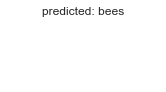

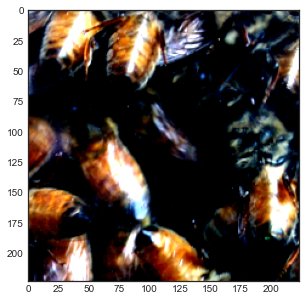

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


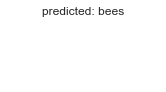

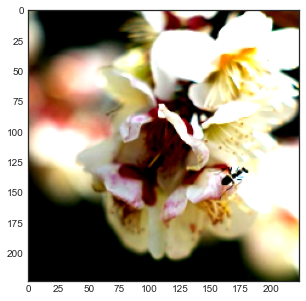

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


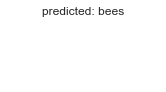

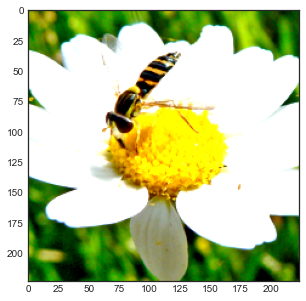

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


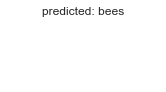

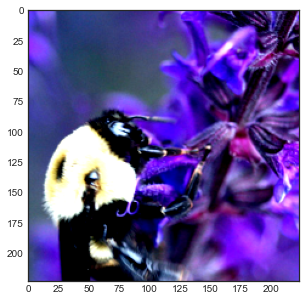

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


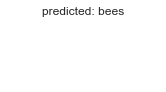

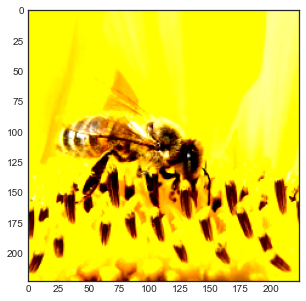

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


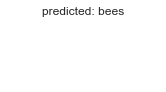

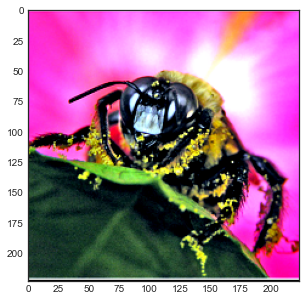

In [45]:
visualize_model(model_conv)